In [45]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from features import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


matplotlib.rcParams['figure.figsize'] = (16, 12)
%matplotlib inline


In [46]:
# Dataset 1: User demographics
df = pd.read_csv('../data/interim/user_purchases.csv', parse_dates=['date','reg_date'], infer_datetime_format=True)
df.head()

,date,uid,sku,price,reg_date,device,gender,country,age,first_week_purchases
0,2018-03-14,84715271.0,sku_two_299,299,2018-03-09,and,M,USA,34,1
1,2018-03-16,84715271.0,sku_two_299,299,2018-03-09,and,M,USA,34,1
2,2018-01-14,47315877.0,sku_three_499,499,2018-01-07,iOS,F,BRA,15,1
3,2018-01-15,47315877.0,sku_one_199,199,2018-01-07,iOS,F,BRA,15,0
4,2018-01-16,47315877.0,sku_two_299,299,2018-01-07,iOS,F,BRA,15,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92027 entries, 0 to 92026
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  92027 non-null  datetime64[ns]
 1   uid                   92027 non-null  float64       
 2   sku                   92027 non-null  object        
 3   price                 92027 non-null  int64         
 4   reg_date              92027 non-null  datetime64[ns]
 5   device                92027 non-null  object        
 6   gender                92027 non-null  object        
 7   country               92027 non-null  object        
 8   age                   92027 non-null  int64         
 9   first_week_purchases  92027 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 7.0+ MB


In [48]:
current_time = df.reg_date.max()
lapse_date = timedelta(days=14)
max_lapse_date = current_time - lapse_date

conv_sub_data = df[df.reg_date<max_lapse_date]

sub_time = conv_sub_data.date - conv_sub_data.reg_date
conv_sub_data['sub_time'] = sub_time
conv_sub_data.head()

/var/folders/14/7mcklss54hzfhxsq9f0x6x100000gn/T/ipykernel_27037/4040408584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_sub_data['sub_time'] = sub_time


,date,uid,sku,price,reg_date,device,gender,country,age,first_week_purchases,sub_time
2,2018-01-14,47315877.0,sku_three_499,499,2018-01-07,iOS,F,BRA,15,1,7 days
3,2018-01-15,47315877.0,sku_one_199,199,2018-01-07,iOS,F,BRA,15,0,8 days
4,2018-01-16,47315877.0,sku_two_299,299,2018-01-07,iOS,F,BRA,15,0,9 days
5,2018-01-25,47315877.0,sku_four_599,599,2018-01-07,iOS,F,BRA,15,0,18 days
6,2018-01-27,47315877.0,sku_four_599,599,2018-01-07,iOS,F,BRA,15,0,20 days


In [49]:
conv_sub_data['sub_time'] = conv_sub_data['sub_time'].dt.days

/var/folders/14/7mcklss54hzfhxsq9f0x6x100000gn/T/ipykernel_27037/3589588155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_sub_data['sub_time'] = conv_sub_data['sub_time'].dt.days


In [50]:
conv_base = conv_sub_data[(conv_sub_data.sub_time.notnull()) | (conv_sub_data.sub_time > 7)]
total_user = len(conv_base)
total_user

90572

In [51]:
total_subs = np.where((conv_base.sub_time.notnull()) & (conv_base.sub_time <= 14), 1 ,0)
total_subs = sum(total_subs)
total_subs

12418

In [52]:
conversion_rate = total_subs / total_user
conversion_rate

0.13710639049595902

In [53]:
conversion_data = conv_sub_data.groupby(by='reg_date', as_index=False).agg({'sub_time': gc7})
conversion_data.head()

,reg_date,sub_time
0,2017-06-01,0.021368
1,2017-06-02,0.034014
2,2017-06-03,0.041894
3,2017-06-04,0.045000
4,2017-06-05,0.033846


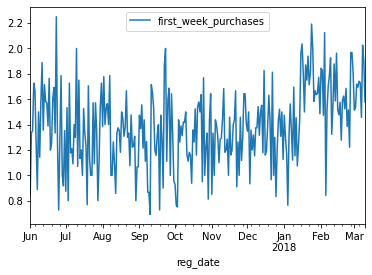

In [54]:
# Group the data and aggregate first_week_purchases
user_purchases = df.groupby(by=['reg_date', 'uid']).agg({'first_week_purchases': ['sum']})

# Reset the indexes
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)

# Find the average number of purchases per day by first-week users
user_purchases = user_purchases.groupby(by=['reg_date']).agg({'first_week_purchases': ['mean']})
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)

# Plot the results 
user_purchases.plot(x='reg_date', y='first_week_purchases')
plt.show()

In [55]:
user_purchases_country = df.groupby(by=['reg_date','country'], as_index=False).agg({'first_week_purchases':'mean'})
# Pivot the data 
country_pivot = pd.pivot_table(user_purchases_country, values=['first_week_purchases'], columns=['country'], index=['reg_date'], fill_value=0)
print(country_pivot.head())

           first_week_purchases                                          \
country                     BRA       CAN       DEU       FRA       TUR   
reg_date                                                                  
2017-06-01             0.044118  0.000000  0.029412  0.000000  0.008772   
2017-06-02             0.046512  0.000000  0.014085  0.000000  0.019231   
2017-06-03             0.032258  0.066667  0.037037  0.038835  0.096774   
2017-06-04             0.075472  0.000000  0.037037  0.075472  0.000000   
2017-06-05             0.054945  0.000000  0.000000  0.000000  0.047059   

                      
country          USA  
reg_date              
2017-06-01  0.034483  
2017-06-02  0.043103  
2017-06-03  0.040268  
2017-06-04  0.037634  
2017-06-05  0.031250  


In [56]:
user_purchases_device = df.groupby(by=['reg_date','device'], as_index=False).agg({'first_week_purchases':'count'})
# Pivot the data
device_pivot = pd.pivot_table(user_purchases_device, values=['first_week_purchases'], columns=['device'], index=['reg_date'])
print(device_pivot.head())

           first_week_purchases     
device                      and  iOS
reg_date                            
2017-06-01                  199  269
2017-06-02                  160  281
2017-06-03                  296  253
2017-06-04                  183  217
2017-06-05                  307   18


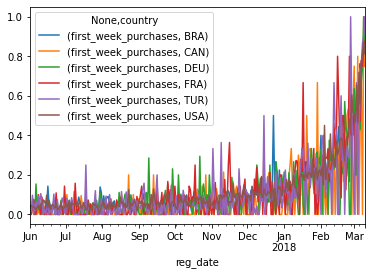

In [57]:
country_pivot = country_pivot.reset_index()
country_pivot.head()
# Plot the average first week purchases for each country by registration date
country_pivot.plot(x='reg_date', y=[('first_week_purchases', 'BRA'),
            ('first_week_purchases', 'CAN'),
            ('first_week_purchases', 'DEU'),
            ('first_week_purchases', 'FRA'),
            ('first_week_purchases', 'TUR'),
            ('first_week_purchases', 'USA')])
plt.show()

In [58]:
usa_subscription = conv_sub_data[conv_sub_data['country']=='USA']

In [59]:
usa_subscription =  usa_subscription[usa_subscription.sub_time <= 7]

In [60]:
usa_subscription = usa_subscription.groupby(by='date', as_index=False).agg({'first_week_purchases':'sum'})
usa_subscription.head()

,date,first_week_purchases
0,2017-06-02,3
1,2017-06-03,2
2,2017-06-04,4
3,2017-06-05,5
4,2017-06-06,4


<AxesSubplot:xlabel='date'>

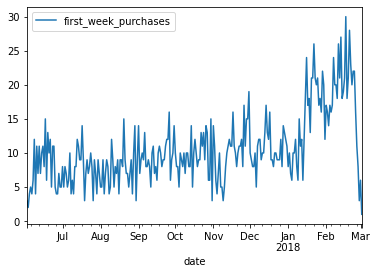

In [61]:
usa_subscription.plot(x='date', y='first_week_purchases')

In [62]:
rolling_subs = usa_subscription.first_week_purchases.rolling(
    window=7,
    center=False
)
rolling_subs

Rolling [window=7,center=False,axis=0,method=single]

In [63]:
usa_subscription['rolling_subs'] = rolling_subs.mean()
usa_subscription.tail()

,date,first_week_purchases,rolling_subs
269,2018-02-26,11,20.285714
270,2018-02-27,8,17.428571
271,2018-02-28,3,14.571429
272,2018-03-01,6,12.571429
273,2018-03-02,1,9.571429


<AxesSubplot:xlabel='date'>

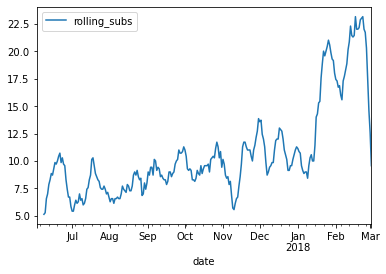

In [64]:
usa_subscription.plot(x='date', y='rolling_subs')

In [113]:
daily_revenue = pd.read_csv('../data/interim/daily_revenue.csv', parse_dates=['date'], infer_datetime_format=True)
subscription = daily_revenue.groupby(by='date', as_index=False).agg({'revenue':'mean'})
plt.figure(figsize=(10,8))
subscription.head()


,date,revenue
0,2013-09-20,26010.125
1,2013-09-21,24970.675
2,2013-09-22,23772.700
3,2013-09-23,22273.675
4,2013-09-24,23564.050


<Figure size 720x576 with 0 Axes>

In [114]:
# Compute 7_day_rev
subscription['week_day_rev'] = subscription.revenue.rolling(window=7,center=False).mean()

# Compute 28_day_rev
subscription['month_day_rev'] = subscription.revenue.rolling(window=28,center=False).mean()
    
# Compute 365_day_rev
subscription['year_day_rev'] = subscription.revenue.rolling(window=365,center=False).mean()
    
# Plot date, and revenue, along with the 3 rolling functions (in order)    
subscription.dropna(inplace=True)

subscription.head()

,date,revenue,week_day_rev,month_day_rev,year_day_rev
364,2014-09-19,24718.525,24291.292857,24471.666071,24941.156918
365,2014-09-20,23839.475,24157.014286,24453.894643,24935.209932
366,2014-09-21,22636.950,24046.267857,24405.791071,24928.816164
367,2014-09-22,21291.000,23851.603571,24395.777679,24922.016986
368,2014-09-23,22995.025,23786.303571,24367.085714,24923.993288


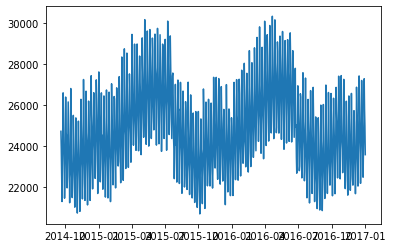

In [115]:
plt.plot(subscription.date, subscription.revenue)

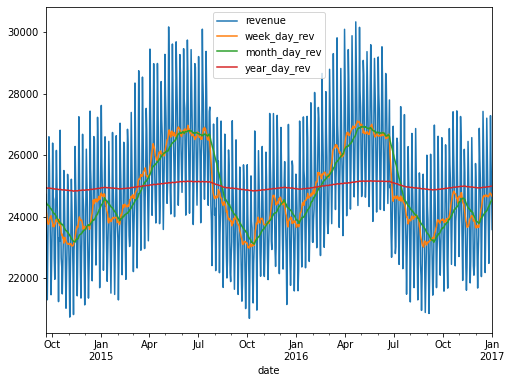

In [119]:

subscription.plot(x='date', y=['revenue','week_day_rev','month_day_rev','year_day_rev'], figsize=(8,6))
plt.show()

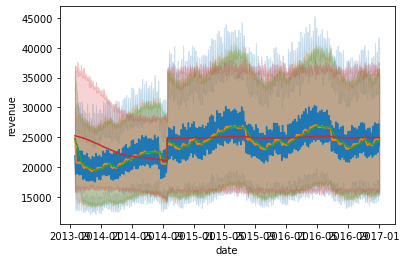

In [92]:
sns.lineplot(x='date', y='revenue', data = daily_revenue)
sns.lineplot(x='date', y='7_day_rev', data = daily_revenue)
sns.lineplot(x='date', y='28_day_rev', data = daily_revenue)
sns.lineplot(x='date', y='365_day_rev', data = daily_revenue)
plt.show()

          date    revenue  week_day_rev  month_day_rev  year_day_rev  \
364 2014-09-19  24718.525  24291.292857   24471.666071  24941.156918   
365 2014-09-20  23839.475  24157.014286   24453.894643  24935.209932   
366 2014-09-21  22636.950  24046.267857   24405.791071  24928.816164   
367 2014-09-22  21291.000  23851.603571   24395.777679  24922.016986   
368 2014-09-23  22995.025  23786.303571   24367.085714  24923.993288   

      small_scale  medium_scale   large_scale  
364  24718.525000  24718.525000  24718.525000  
365  24235.047500  24274.604750  24278.120950  
366  23592.622924  23717.766108  23728.874283  
367  22834.340718  23092.753722  23115.744035  
368  22880.468805  23072.418409  23091.406692  


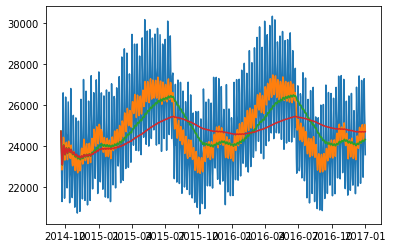

In [120]:
# Calculate 'small_scale'
subscription['small_scale'] = subscription.revenue.ewm(span=10).mean()

# Calculate 'medium_scale'
subscription['medium_scale'] = subscription.revenue.ewm(span=100).mean()

# Calcualte 'large_scale'
subscription['large_scale'] = subscription.revenue.ewm(span=500).mean()
print(subscription.head())
# Plot the date, and the raw data plus the calculated averages
plt.plot(subscription[['date']], subscription[['revenue','small_scale', 'medium_scale', 'large_scale']], 
alpha=1)
plt.show()

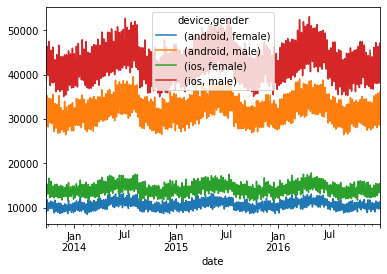

In [121]:
# Pivot user_revenue
pivoted_data = pd.pivot_table(daily_revenue, values='revenue', columns=['device', 'gender'], index='date')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

# Create and show the plot
pivoted_data.plot()
plt.show()